In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%time

import os, shutil, tarfile, requests
%tensorflow_version 2.x
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorboard import notebook
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from keras import backend as K
from keras.models import load_model
from keras.models import Model
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import MaxPooling2D
from keras.layers import Conv2D
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Dense
!pip install -U keras-tuner
import keras_tuner as kt
import IPython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 5.0 MB/s 
CPU times: user 2.3 s, sys: 379 ms, total: 2.68 s
Wall time: 6.35 s


## 1  Preprocessing des images

In [3]:
VM_ROOT = '/content/drive/MyDrive/fences'
DATA_PATH = os.path.join(VM_ROOT)
os.makedirs(DATA_PATH, exist_ok=True)

img_loc ='/content/drive/MyDrive/fences/images'
if img_loc.find('/'):
  fname = img_loc.rsplit('/', 1)[1]

## 1.1. Visualisation de la liste des anomaly

In [7]:
#Count the number of classes (dogs breeds=race de chiens )
fence_list = os.listdir('/content/drive/MyDrive/fences/images')
print("Number of classes in dataset:", (len(fence_list)))

Number of classes in dataset: 2


In [6]:
import pandas as pd

# Count number of pictures for each breed
df_fences = pd.DataFrame(
    index=[fence.split('-',1)[1]
           #for fence in fence_list],
    data=[len(os.listdir(img_loc+ "/" + name))
          for name in fence_list],
    columns=["num_pictures"])

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(15,8))
df_fences.plot(kind="bar",
               legend=False,
               ax=ax)
ax.axhline(df_breeds["num_pictures"].mean(),
           color='r', alpha=.7,
           linestyle='--',
           label="Mean of pictures")
plt.title("Number of pictures for each "\
          "classes of Dataset",
          color="#343434", fontsize=25)
plt.legend()
plt.show()

SyntaxError: ignored

On remarque que les races de chien sont toutes bien alimentées en images. La moyenne se situe à 171 photos par classe. Aucune race n'est sous représentée nous pouvons donc toutes les conserver pour le moment.

Regardons quelques exemples des photos par races disponibles dans la base d'étude :

In [8]:
import matplotlib.image as mpimg
def show_images_classes(path, classes, num_sample):
    
    fig = plt.figure(figsize=(20,20))
    fig.patch.set_facecolor('#343434')
    plt.suptitle("{}".format(classes.split("-")[1]), y=.83,
                 color="white", fontsize=22)
    images = os.listdir(path + "/" + classes)[:num_sample]
    for i in range(num_sample):
        img = mpimg.imread(path+"/"+classes+"/"+images[i])
        plt.subplot(num_sample/5+1, 5, i+1)
        plt.imshow(img)
        plt.axis('on')# tnjem off
    plt.show()

Nous allons devoir modifier la taille des images pour qu'elles s'adaptent aux contraintes du modèle CNN de transfert learning. Cela aura également pour effet de diminuer les temps de calculs de notre modèle "from scratch".

## 1.2. Modification de la taille des images
On peut remarquer dans les images en exemple ci-dessus que les chiens présents sur les photos ne sont pas toujours au centre de la photo, que les zooms sont différents. Redimensionner les images ne va pas changer ces attributs, l'image va même être déformée pour coller au nouvelles dimensions.

Nous allons réaliser la transformation sur une image test pour commencer.

In [9]:
import cv2 as cv
# Define test image
img_test = (img_loc
            + "/" 
            + "normal/3D-Curved-Wire-Mesh-Fencing-Panel-for-Fence.jpg")
img_test = cv.imread(img_test)

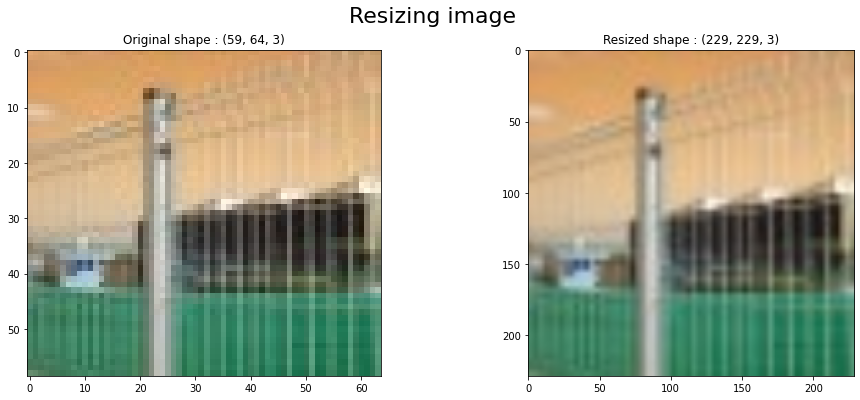

In [10]:
# setting dim of the resize
height = 229
width = 229
dim = (width, height)
# resize image with OpenCV
res_img = cv.resize(img_test, dim, interpolation=cv.INTER_LINEAR)

# Show both img
fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.imshow(img_test)
plt.title("Original shape : {}".format(img_test.shape))
plt.subplot(1, 2, 2)
plt.imshow(res_img)
plt.title("Resized shape : {}".format(res_img.shape))
plt.suptitle("Resizing image",
             color="black", 
             fontsize=22, y=.98)
plt.show()


On voit bien ici que le redimensionnement en 229 x 229 déforme la photo initiale. Une fois ce filtre appliqué à toutes les images, elles seront probablement toutes déformées.

Autre fait, avec un set d'image relativement important, les expositions, contraste, ... sont relativement différents pour chaque photo. Nous allons à présent utiliser des méthodes basées sur les histogrammes de ces images pour pre-processer au mieux ces données.

## 1.3. Modification de l'histogramme des images
L'histogramme d'une image numérique est une courbe statistique représentant la répartition de ses pixels selon leur intensité. Commençons par regarder une image en particulier.

Nous allons transformer l'image dans différents codages couleurs. Le système de codage YUV est créé depuis une source RVB. Il est codé en trois composantes : Y représente la luminance (informations de luminosité) tandis que les deux autres (U et V) sont des données de chrominance (informations de couleur). Ce format nous permet de visualiser au mieux l'histogramme pour les 3 dimensions :

In [11]:
# Transform image with differents color sets
img_RGB = cv.cvtColor(img_test, cv.COLOR_BGR2RGB)
img_grayscale = cv.cvtColor(img_test, cv.COLOR_RGB2GRAY)
img_YUV = cv.cvtColor(img_test,cv.COLOR_BGR2YUV)
# Create histogram
def plot_histogram(init_img, convert_img):
    hist, bins = np.histogram(
                    convert_img[1].flatten(),
                    256, [0,256])
    # Cumulative Distribution Function
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()

    # Plot histogram
    fig = plt.figure(figsize=(25,6))
    plt.subplot(1, 3, 1)
    plt.imshow(init_img[1])
    plt.title("{} Image".format(init_img[0]), 
              color="#343434")
    plt.subplot(1, 3, 2)
    plt.imshow(convert_img[1])
    plt.title("{} Image".format(convert_img[0]), 
              color="#343434")
    plt.subplot(1, 3, 3)
    plt.plot(cdf_normalized, 
             color='r', alpha=.7,
             linestyle='--')
    plt.hist(convert_img[1].flatten(),256,[0,256])
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    plt.title("Histogram of convert image", color="#343434")
    plt.suptitle("Histogram and cumulative "\
                 "distribution for test image",
              color="black", fontsize=22, y=.98)
    plt.show()


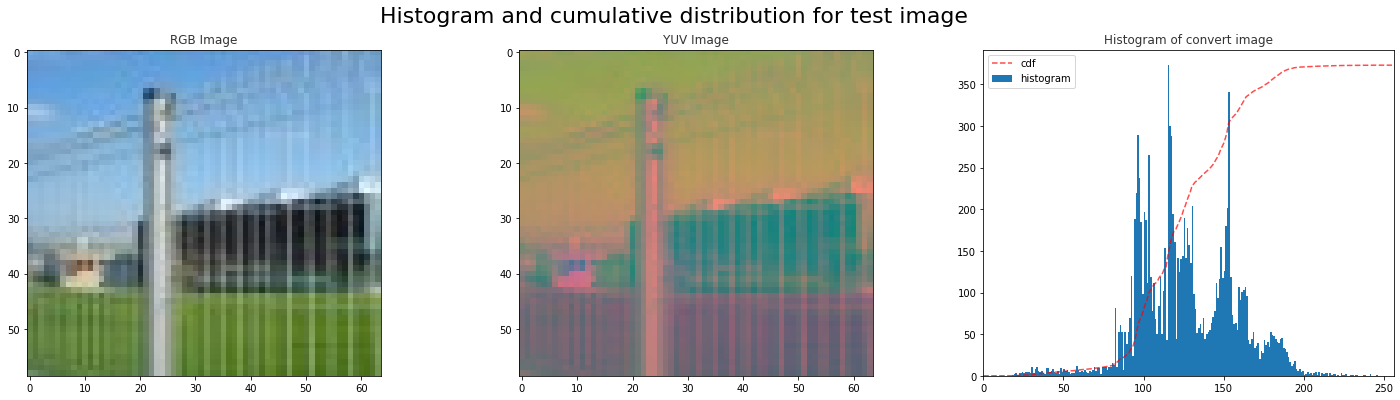

In [ ]:
plot_histogram(["RGB", img_RGB], ["YUV", img_YUV])

**Egalisation**

On constate ici des pics importants au centre de l'histogram. Dans le cadre d'une bonne égalisation càd "amélioration du contraste", il est nécessaire de répartir la lumière dans tout le spectre de l'image.

Testons l'égalisation avec OpenCV : L'intérêt de convertir l'image dans l'espace colorimétrique YUV est de pouvoir agir sur le canal "luminance" (Y) indépendamment des autres canaux de chrominance. Nous allons donc réaliser l'égalisation sur ce seul canal Y :

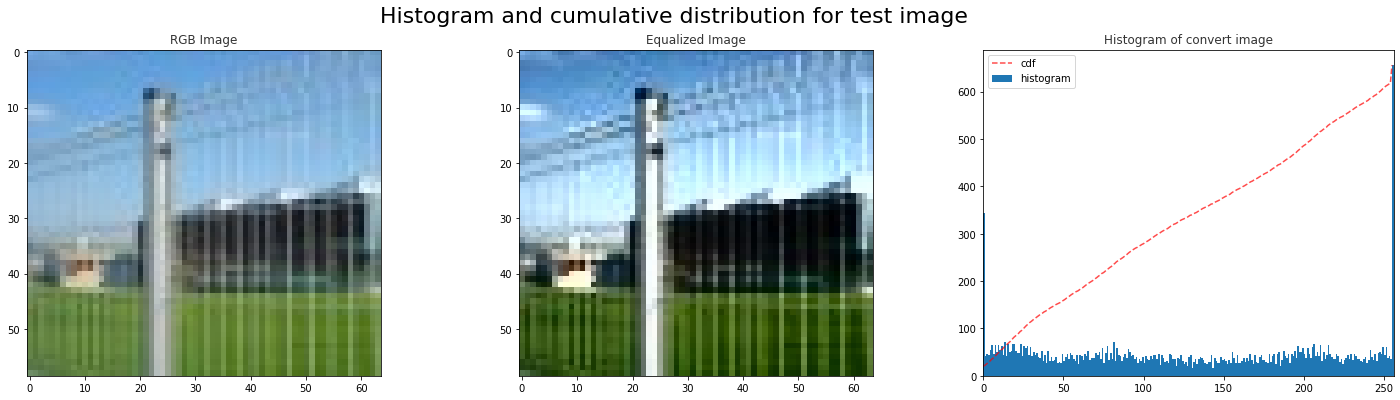

In [12]:
#Equalization
img_YUV[:,:,0] = cv.equalizeHist(img_YUV[:,:,0])
img_equ = cv.cvtColor(img_YUV, cv.COLOR_YUV2RGB)
plot_histogram(["RGB", img_RGB], ["Equalized", img_equ])

L'image résultante est donc bien égualisée, l'histogramme couvre l'ensemble du spectre et la CDF est constante et linéaire. Ce pré-traitement sera donc appliqué à l'ensemble des images.



## 1.4. Application de filtres
Les images peuvent pour de nombreuses raisons être bruitées, c'est à dire comporter des pixels atypiques qui peuvent fausser la détection de features. Par exemple de causes de bruits :

Caractéristiques de l'appareil photo, Compression des images JPEG Mauvaise résolution ... Pour rémidier au bruit présent dans les images, il est possible d'appliquer un filtre. Il en existe de plusieurs types : les filtres linéaires (comme le filtre Gaussien), non linéaires comme le filtre médian par exemple. un des meilleurs filtre pour débruiter l'image est le filtre non-local means.

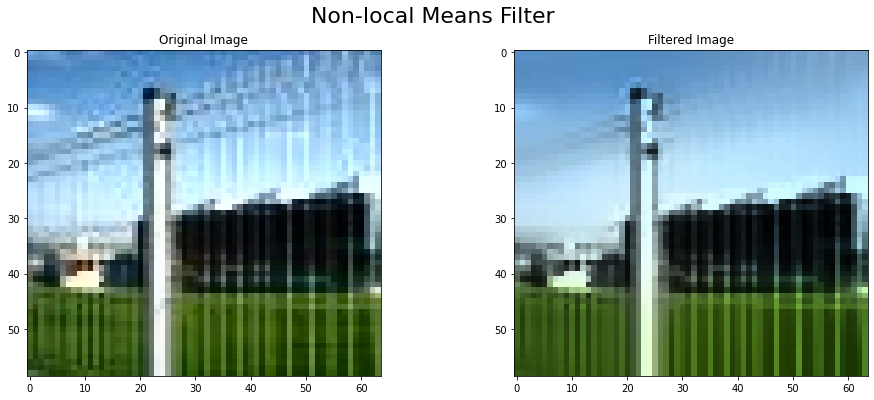

In [13]:
dst_img = cv.fastNlMeansDenoisingColored(
    src=img_equ,
    dst=None,
    h=10,
    hColor=10,
    templateWindowSize=7,
    searchWindowSize=21)

# Show both img
fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.imshow(img_equ)
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(dst_img)
plt.title("Filtered Image")
plt.suptitle("Non-local Means Filter",
             color="black", 
             fontsize=22, y=.98)
plt.show()

In [14]:
import random

num_classes=2
list_dir_fences = random.sample(fence_list,num_classes)
list_dir_fences

['anomaly', 'normal']

## 1.5 Fragmentation de data

In [15]:
import shutil #delete all the contents of a directory
shutil.rmtree("/content/drive/MyDrive/fences/val")
shutil.rmtree("/content/drive/MyDrive/fences/train")
shutil.rmtree("/content/drive/MyDrive/fences/test")

In [16]:
IMAGES_PATH = os.path.join(DATA_PATH,img_loc)

TRAIN_PATH = os.path.join(DATA_PATH, "train")
os.makedirs(TRAIN_PATH, exist_ok=True)

VAL_PATH = os.path.join(DATA_PATH, "val")
os.makedirs(VAL_PATH, exist_ok=True)

TEST_PATH = os.path.join(DATA_PATH, "test")
os.makedirs(TEST_PATH, exist_ok=True)

val_threshold = 0.75
test_threshold = val_threshold + 0.15

train_size = 0
val_size = 0
test_size = 0
num_classes = 0

for breed_dir in os.listdir(IMAGES_PATH):
  num_classes +=1
  breed_dir_path = os.path.join(IMAGES_PATH, breed_dir)
  breed_train_path = os.path.join(TRAIN_PATH, breed_dir)
  breed_val_path = os.path.join(VAL_PATH, breed_dir)
  breed_test_path = os.path.join(TEST_PATH, breed_dir)
  os.makedirs(breed_train_path, exist_ok=True)
  os.makedirs(breed_val_path, exist_ok=True)
  os.makedirs(breed_test_path, exist_ok=True)
  breed_list = os.listdir(breed_dir_path)
  breed_size = len(breed_list)
  breed_val_threshold = math.ceil(breed_size *  val_threshold)
  breed_test_threshold = math.ceil(breed_size * test_threshold)
  breed_train_range = breed_list[:breed_val_threshold]
  breed_val_range = breed_list[breed_val_threshold:breed_test_threshold]
  breed_test_range = breed_list[breed_test_threshold:breed_size]

  try:
    assert len(breed_train_range) + len(breed_val_range) + len(breed_test_range) == breed_size
  except AssertionError :
    print("Toutes les photos de la race ne sont pas prise en compte")
    print(f"Pour la race {breed_dir}")
    break

  for i, image in enumerate(breed_train_range):
    src = os.path.join(breed_dir_path, image)
    dest = os.path.join(breed_train_path, image)
    shutil.copyfile(src, dest)
    train_size += 1

  for _, image in enumerate(breed_val_range):
    src = os.path.join(breed_dir_path, image)
    dest = os.path.join(breed_val_path, image)
    shutil.copyfile(src, dest)
    val_size +=1

  for _, image in enumerate(breed_test_range):
    src = os.path.join(breed_dir_path, image)
    dest = os.path.join(breed_test_path, image)
    shutil.copyfile(src, dest)
    test_size +=1
  
print("... Data split done ...")
print(f"Nombre de classes: {num_classes}")
print(f"train set size: {train_size}")
print(f"val set size: {val_size}")
print(f"test set size: {test_size}")

... Data split done ...
Nombre de classes: 2
train set size: 89
val set size: 18
test set size: 11


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(TRAIN_PATH,
                                              target_size=(229,229),
                                              batch_size=32,
                                              class_mode="categorical")

val_generator = datagen.flow_from_directory(VAL_PATH,
                                          target_size=(229,229),
                                          batch_size=32,
                                          class_mode='categorical')

Found 89 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


# 2 Construction du modèle CNN

### 2.1 CNN 3 Layers

In [17]:
K.clear_session()
model = Sequential()
# Convolution layer
model.add(Conv2D(filters=16,
                 kernel_size=(3,3), 
                 padding='same',
                 use_bias=False,
                 input_shape=(229,229,3)))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation('relu'))
# Pooling layer
model.add(MaxPooling2D(pool_size=(4, 4),
                       strides=(4, 4),
                       padding='same'))
# Second convolution layer
model.add(Conv2D(filters=32,
                 kernel_size=(3,3), 
                 padding='same',
                 use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4, 4), 
                       strides=(4, 4), 
                       padding='same'))
model.add(Dropout(0.2))
# Third convolution layer
model.add(Conv2D(filters=64,
                 kernel_size=(3,3), 
                 padding='same',
                 use_bias=False))

model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation('relu'))
model.add(GlobalAveragePooling2D())
# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 229, 229, 16)      432       
                                                                 
 batch_normalization (BatchN  (None, 229, 229, 16)     48        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 229, 229, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 58, 58, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 32)        4608      
                                                                 
 batch_normalization_1 (Batc  (None, 58, 58, 32)       9

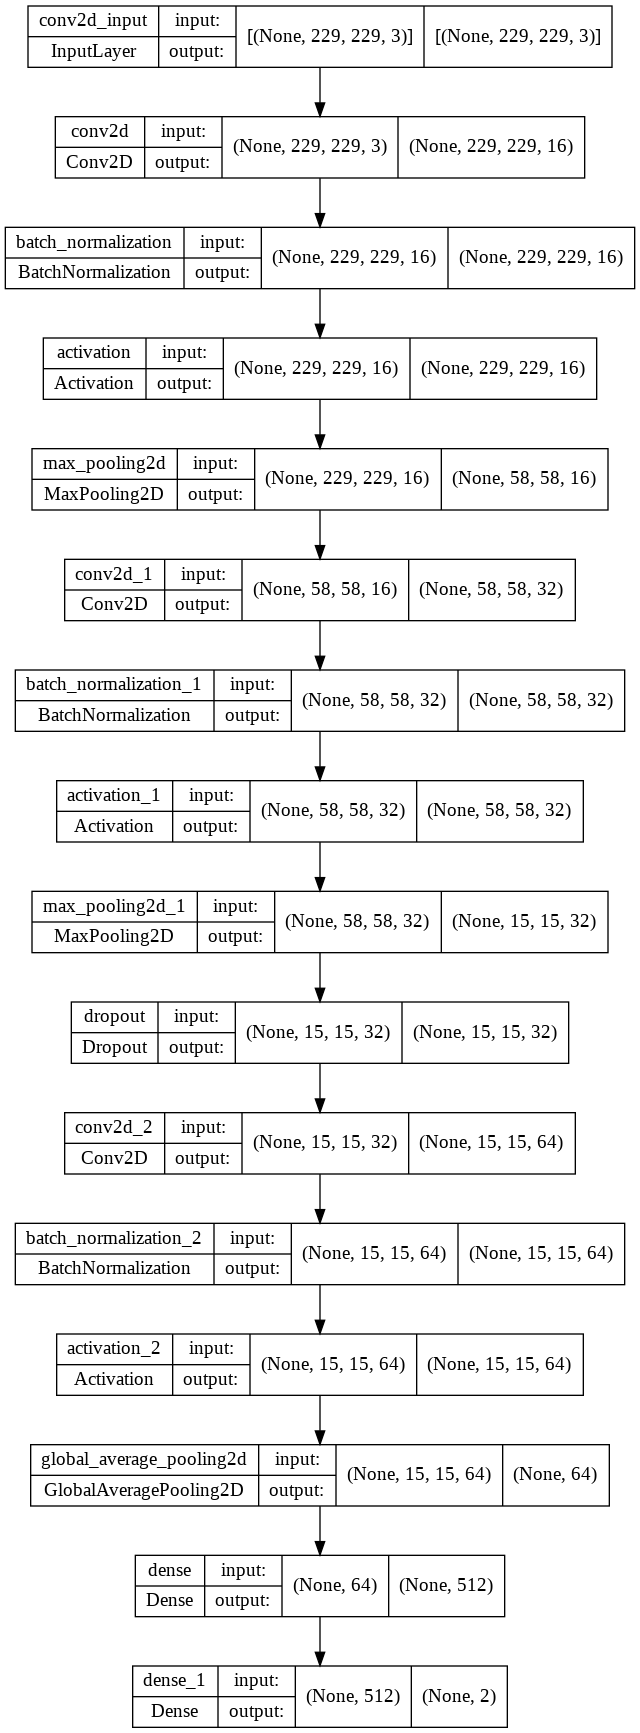

In [18]:
FIGS_PATH = os.path.join(VM_ROOT, "figures")
os.makedirs(FIGS_PATH, exist_ok=True)
keras.utils.plot_model(model, FIGS_PATH + "/my_CNN_model_3.png", show_shapes=True)

In [19]:
#Checkpoint de sauvegarde
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [20]:
MODELS_PATH = os.path.join(VM_ROOT, "models")
os.makedirs(MODELS_PATH, exist_ok=True)
FILE_PATH = MODELS_PATH + "/my_CNN_model_3.h5"

In [21]:
%%time

from keras.preprocessing.image import ImageDataGenerator



MODELS_PATH = os.path.join(VM_ROOT, "models")
os.makedirs(MODELS_PATH, exist_ok=True)
FILE_PATH = MODELS_PATH + "/my_CNN_model_3.h5"

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(TRAIN_PATH,
                                              target_size=(299,299),
                                              batch_size=32,
                                              class_mode="categorical")

val_generator = datagen.flow_from_directory(VAL_PATH,
                                          target_size=(299,299),
                                          batch_size=32,
                                          class_mode='categorical')

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=FILE_PATH,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True)
#plot_loss_cb = PlotLossesKeras()


model.compile(loss="categorical_crossentropy", 
            optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

batch_size = 32
epochs =100

history = model.fit(
                train_generator,
                steps_per_epoch = train_size // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps = val_size // batch_size,
                callbacks=[checkpoint_cb,
                           early_stopping_cb])

Found 89 images belonging to 2 classes.
Found 18 images belonging to 2 classes.
Epoch 1/100
2/2 [==============================] - 12s 184ms/step - loss: 0.7525 - accuracy: 0.1562
Epoch 2/100
2/2 [==============================] - 0s 168ms/step - loss: 0.7392 - accuracy: 0.1875
Epoch 3/100
2/2 [==============================] - 1s 424ms/step - loss: 0.7295 - accuracy: 0.1930
Epoch 4/100
2/2 [==============================] - 0s 139ms/step - loss: 0.7271 - accuracy: 0.2105
Epoch 5/100
2/2 [==============================] - 0s 150ms/step - loss: 0.7117 - accuracy: 0.2807
Epoch 6/100
2/2 [==============================] - 0s 156ms/step - loss: 0.7091 - accuracy: 0.3684
Epoch 7/100
2/2 [==============================] - 0s 179ms/step - loss: 0.6947 - accuracy: 0.4561
Epoch 8/100
2/2 [==============================] - 0s 150ms/step - loss: 0.6973 - accuracy: 0.4844
Epoch 9/100
2/2 [==============================] - 0s 173ms/step - loss: 0.6849 - accuracy: 0.6562
Epoch 10/100
2/2 [==========

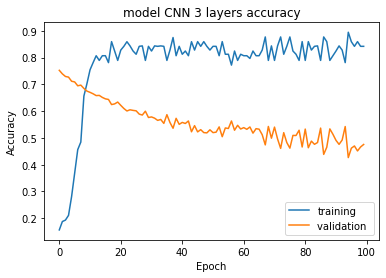

In [24]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history['loss'])
plt.title("model CNN 3 layers accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["training","validation "])
plt.show()


## 2.2 CNN 5 layers

In [26]:
K.clear_session()
model = Sequential()
# Convolution layer
model.add(Conv2D(filters=16,
                 kernel_size=(3,3), 
                 padding='same',
                 use_bias=False,
                 input_shape=(229,229,3)))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation('relu'))
# Pooling layer
model.add(MaxPooling2D(pool_size=(4, 4),
                       strides=(4, 4),
                       padding='same'))
# Second convolution layer
model.add(Conv2D(filters=32,
                 kernel_size=(3,3), 
                 padding='same',
                 use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4, 4), 
                       strides=(4, 4), 
                       padding='same'))
model.add(Dropout(0.2))
# Third convolution layer
model.add(Conv2D(filters=64,
                 kernel_size=(3,3), 
                 padding='same',
                 use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4, 4), 
                       strides=(4, 4), 
                       padding='same'))
#4 convolution layer 
model.add(Conv2D(filters=128,
                 kernel_size=(3,3), 
                 padding='same',
                 use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4, 4), 
                       strides=(4, 4), 
                       padding='same'))
#5convolution layer
model.add(Conv2D(filters=256,
                 kernel_size=(3,3), 
                 padding='same',
                 use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation('relu'))
model.add(GlobalAveragePooling2D())
# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 229, 229, 16)      432       
                                                                 
 batch_normalization (BatchN  (None, 229, 229, 16)     48        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 229, 229, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 58, 58, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 32)        4608      
                                                                 
 batch_normalization_1 (Batc  (None, 58, 58, 32)       9

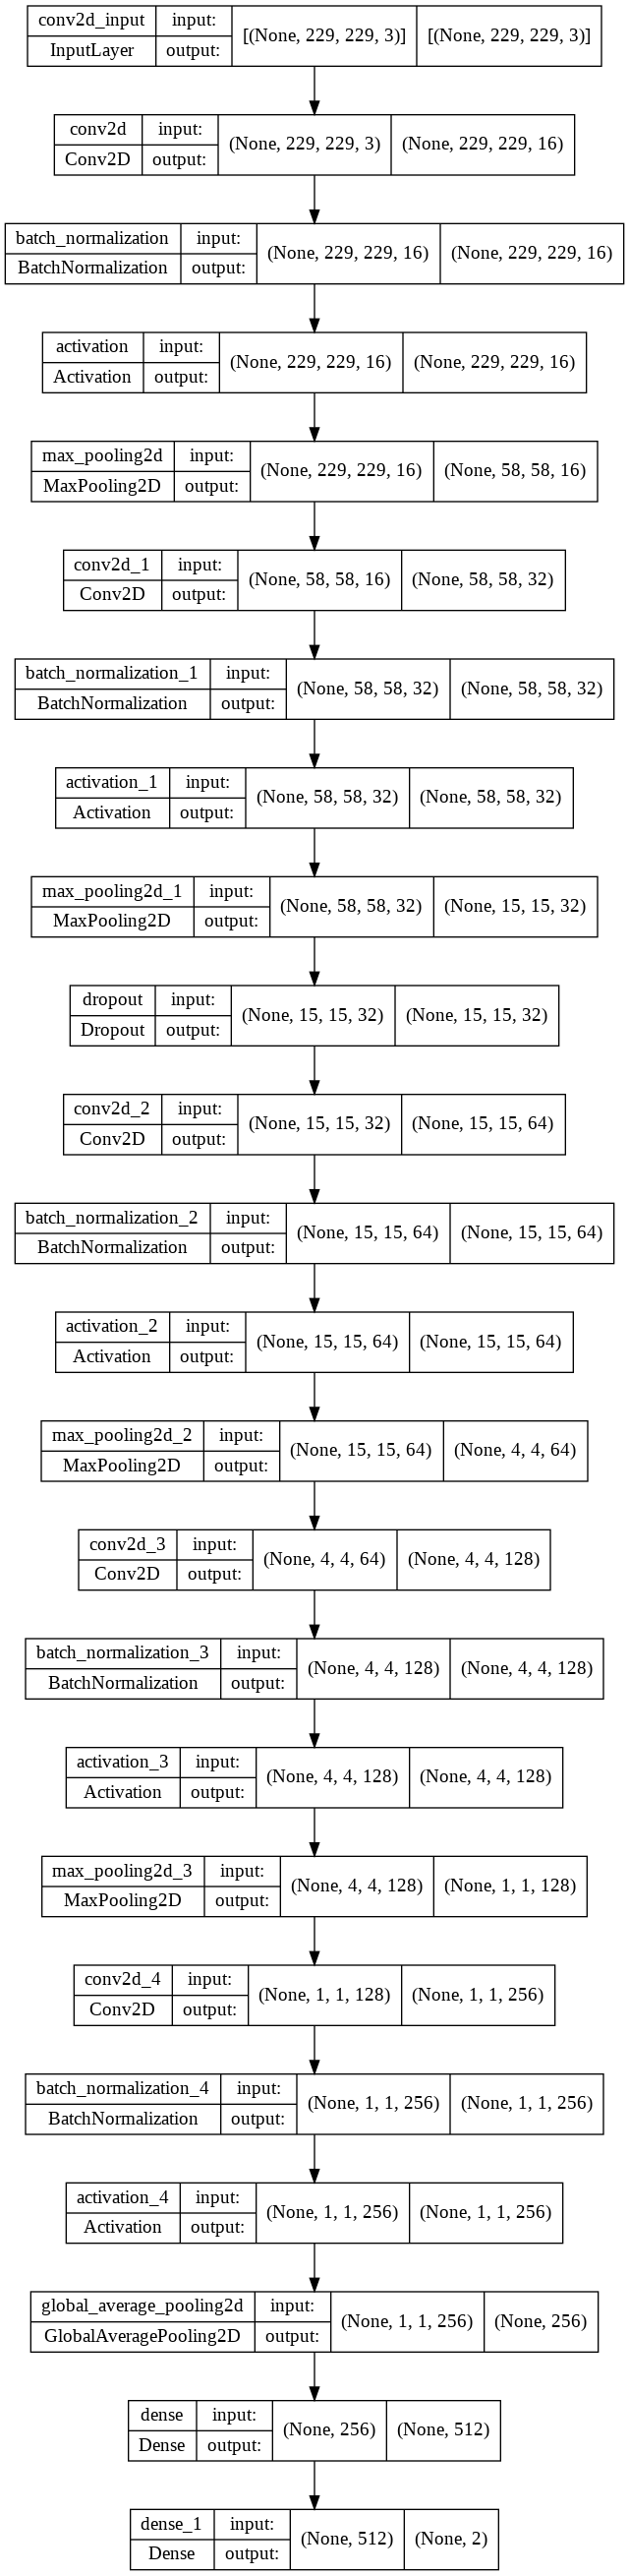

In [27]:
FIGS_PATH = os.path.join(VM_ROOT, "figures")
os.makedirs(FIGS_PATH, exist_ok=True)
keras.utils.plot_model(model, FIGS_PATH + "/my_CNN_model.png", show_shapes=True)

In [28]:
#Checkpoint de sauvegarde
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [29]:
MODELS_PATH = os.path.join(VM_ROOT, "models")
os.makedirs(MODELS_PATH, exist_ok=True)
FILE_PATH = MODELS_PATH + "/my_CNN_model.h5"

In [30]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=FILE_PATH ,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True)

In [31]:
EarlyStopping= keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True)

In [32]:
%%time
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"])

batch_size = 32
epochs = 70

history = model.fit(
                train_generator,
                steps_per_epoch = train_size // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps = val_size // batch_size,
                callbacks=[checkpoint_cb,EarlyStopping])

Epoch 1/70
2/2 [==============================] - 1s 248ms/step - loss: 0.6268 - accuracy: 0.7895
Epoch 2/70
2/2 [==============================] - 0s 194ms/step - loss: 0.6342 - accuracy: 0.7193
Epoch 3/70
2/2 [==============================] - 0s 156ms/step - loss: 0.6335 - accuracy: 0.7368
Epoch 4/70
2/2 [==============================] - 0s 179ms/step - loss: 0.6024 - accuracy: 0.7969
Epoch 5/70
2/2 [==============================] - 0s 132ms/step - loss: 0.5874 - accuracy: 0.7193
Epoch 6/70
2/2 [==============================] - 0s 190ms/step - loss: 0.5500 - accuracy: 0.8421
Epoch 7/70
2/2 [==============================] - 0s 160ms/step - loss: 0.5597 - accuracy: 0.8246
Epoch 8/70
2/2 [==============================] - 0s 133ms/step - loss: 0.5122 - accuracy: 0.9123
Epoch 9/70
2/2 [==============================] - 0s 167ms/step - loss: 0.5129 - accuracy: 0.8246
Epoch 10/70
2/2 [==============================] - 0s 157ms/step - loss: 0.4834 - accuracy: 0.8750
Epoch 11/70
2/2 [==

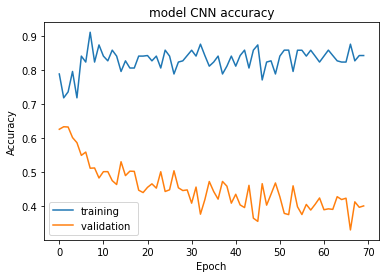

In [33]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history['loss'])
plt.title("model CNN accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["training","validation "])
plt.show()


### 2.3 Data augmentation :

In [34]:
import cv2 as cv
# Define test image
img_test = (img_loc
            + "/" 
            + "normal/3D-Curved-Wire-Mesh-Fencing-Panel-for-Fence.jpg")
img_test = cv.imread(img_test)

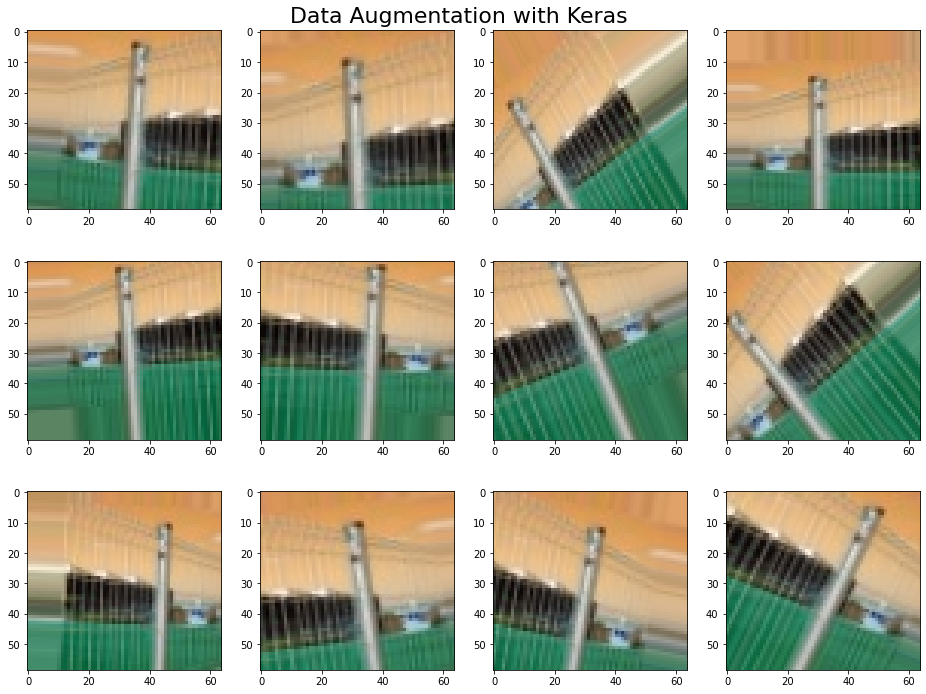

In [35]:
from keras.preprocessing import image
#Initilize Data Generator Keras
augmented_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Convert test img to array
x = image.img_to_array(img_test)
x = x.reshape((1,) + x.shape)

i=0
fig = plt.figure(figsize=(16,12))
for batch in augmented_datagen.flow(x, batch_size=1):
    ax = fig.add_subplot(3,4,i+1)
    ax.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 12 == 0:
        break

plt.suptitle("Data Augmentation with Keras",
             color="black", 
             fontsize=22, y=.90)
plt.show()

In [36]:
# Data generator on train set with Data Augmentation
# Validation set is define here
train_datagen = ImageDataGenerator(rescale=1./255,

                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  channel_shift_range=20,
                                  horizontal_flip=True,
                                  )

#For validation and test, just rescale

val_datagen = ImageDataGenerator(rescale=1./255)

In [37]:
%%time
batch_size=32
train_datagen = ImageDataGenerator(rescale=1./255,

                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  channel_shift_range=20,
                                  horizontal_flip=True,
                                  )

train_generator =train_datagen.flow_from_directory(TRAIN_PATH,
                                     target_size=(229,229),
                                     shuffle=True,
                                     batch_size=batch_size,
                                     class_mode="categorical")


val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory( VAL_PATH,
                                     target_size=(229,229),
                                     shuffle=False,
                                      batch_size=batch_size,
                                      class_mode='categorical')

model.compile(loss="categorical_crossentropy", 
              optimizer="Adam",
              metrics=["accuracy"])


MODELS_PATH = os.path.join(VM_ROOT, "models")
os.makedirs(MODELS_PATH, exist_ok=True)
FILE_PATH = MODELS_PATH + "/my_CNN_model_data_augmented.h5"


checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=FILE_PATH,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='min')
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min',
                                                  restore_best_weights=True)


epochs =100
history_cnn = model.fit(
                train_generator,
                steps_per_epoch = train_size // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps = val_size // batch_size,
                 callbacks=[checkpoint_cb,EarlyStopping])

Found 89 images belonging to 2 classes.
Found 18 images belonging to 2 classes.
Epoch 1/100
2/2 [==============================] - 2s 610ms/step - loss: 0.5703 - accuracy: 0.8421
Epoch 2/100
2/2 [==============================] - 1s 376ms/step - loss: 0.5141 - accuracy: 0.8070
Epoch 3/100
2/2 [==============================] - 1s 468ms/step - loss: 0.4201 - accuracy: 0.8070
Epoch 4/100
2/2 [==============================] - 1s 470ms/step - loss: 0.5168 - accuracy: 0.7719
Epoch 5/100
2/2 [==============================] - 1s 470ms/step - loss: 0.4714 - accuracy: 0.7812
Epoch 6/100
2/2 [==============================] - 1s 463ms/step - loss: 0.3205 - accuracy: 0.8750
Epoch 7/100
2/2 [==============================] - 1s 396ms/step - loss: 0.3669 - accuracy: 0.8421
Epoch 8/100
2/2 [==============================] - 1s 492ms/step - loss: 0.2694 - accuracy: 0.9123
Epoch 9/100
2/2 [==============================] - 1s 380ms/step - loss: 0.4018 - accuracy: 0.8421
Epoch 10/100
2/2 [===========

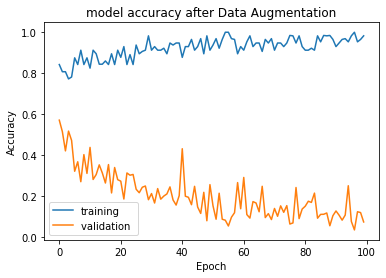

In [38]:
import matplotlib.pyplot as plt

plt.plot(history_cnn.history["accuracy"])
plt.plot(history_cnn.history['loss'])
plt.title("model accuracy after Data Augmentation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["training","validation "])
plt.show()


In [39]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet121(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(LR), 
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.AUC()])
  
    return model

In [40]:
model = define_compile_model()
clear_output()
model.summary()

NameError: ignored

In [41]:
#training
history = model.fit(x = train_generator,validation_data=test_generator,epochs = EPOCHS)

NameError: ignored

# 3 Transfert Learning 
## 3.1 Modèle CNN pré-entrainé Xception

In [42]:
K.clear_session()
# Import Xception trained model
xception_model = tf.keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False, 
    pooling='avg',
    input_shape=(229,229,3))

# look at the differents layers
print("-" * 50)
print("Xception base model layers :")
print("-" * 50)
for layer in xception_model.layers:
    print(layer)

83697664/83683744 [==============================] - 1s 0us/step
--------------------------------------------------
Xception base model layers :
--------------------------------------------------


In [ ]:
num_classes=2
#en entraine seulement le nouveau classifier et on ne ré-entraine pas les autres couches  
for layer in xception_model.layers:
    layer.trainable = False

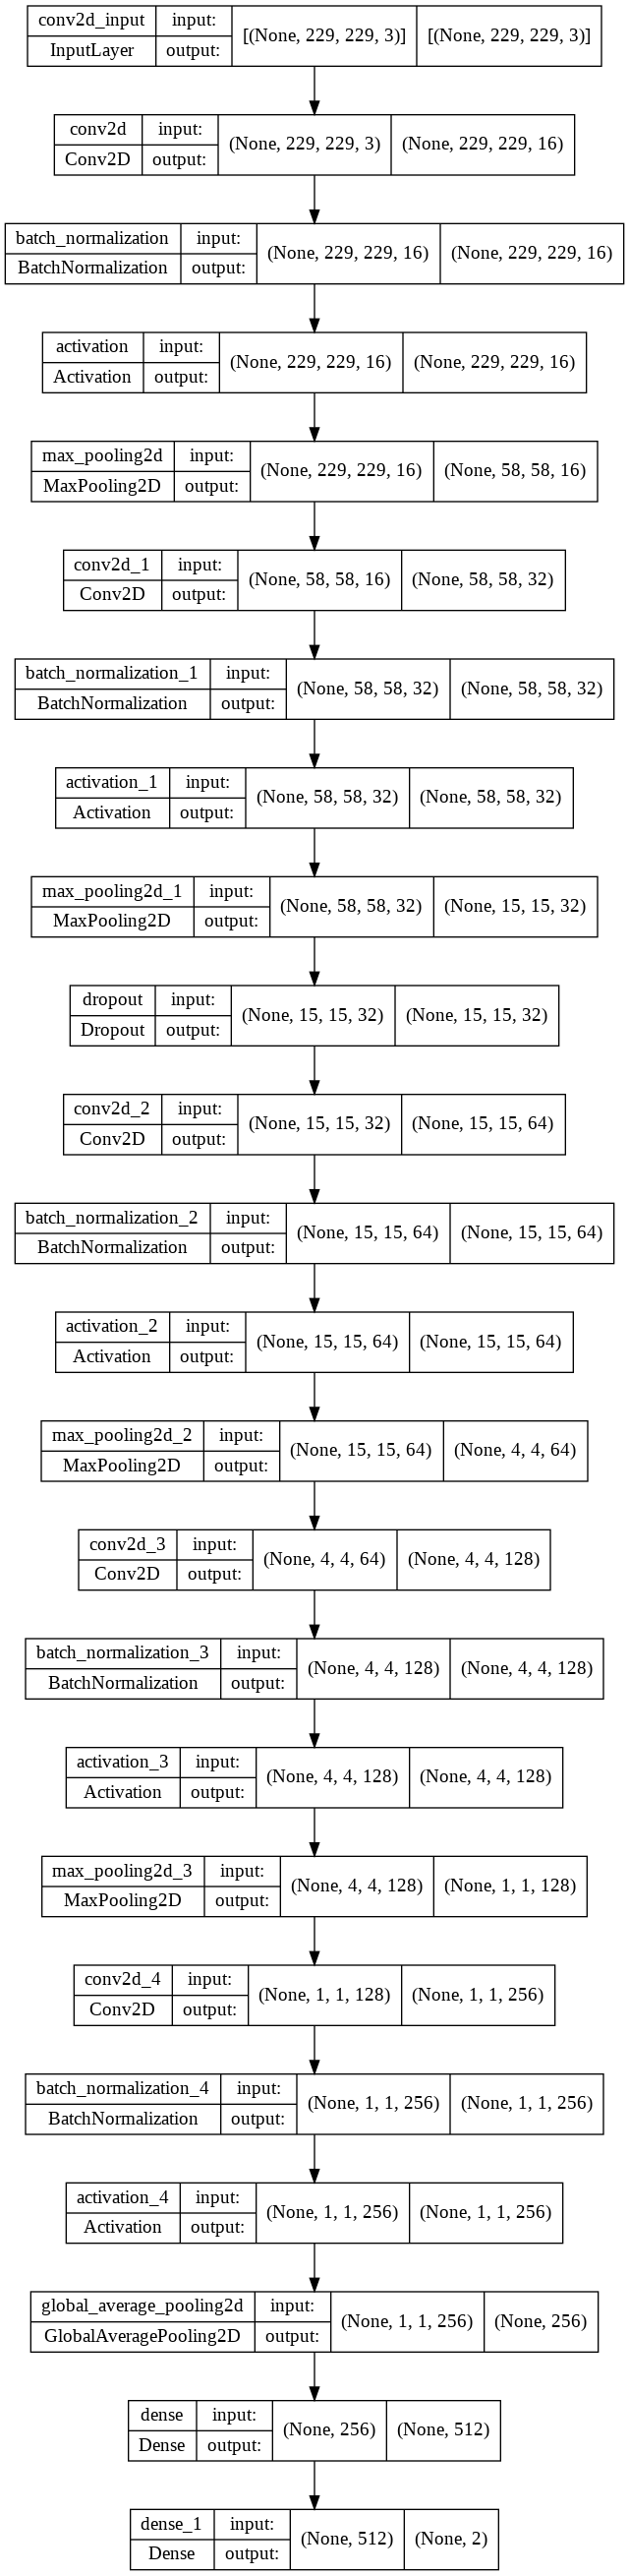

In [43]:
# Add new fully-connected layers
base_output = xception_model.output
base_output = Dense(512, activation='relu')(base_output)
base_output = Dropout(0.2)(base_output)
# Output : new classifier
predictions = Dense(num_classes, activation='softmax')(base_output)


# Define new model
my_xcept_model = Model(inputs=xception_model.input,
                       outputs=predictions)

FIGS_PATH = os.path.join(VM_ROOT, "figures")
os.makedirs(FIGS_PATH, exist_ok=True)
keras.utils.plot_model(model, FIGS_PATH + "/transfer_xcept_model.png", show_shapes=True)

In [44]:
%%time 
import os
batch_size=32
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  channel_shift_range=20,
                                  horizontal_flip=True,
                                  preprocessing_function=tf.keras.applications.xception.preprocess_input)

train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                    target_size=(229,229),
                                                    shuffle=True,
                                                    batch_size=batch_size,
                                                    class_mode="categorical")


val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)


val_generator = val_datagen.flow_from_directory(VAL_PATH,
                                          target_size=(229,229),
                                          shuffle=False,
                                          batch_size=batch_size,
                                       class_mode='categorical')


Found 89 images belonging to 2 classes.
Found 18 images belonging to 2 classes.
CPU times: user 9.88 ms, sys: 2.91 ms, total: 12.8 ms
Wall time: 209 ms


In [45]:
model.compile(optimizer="adam", #moins de param et plus rapide..
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [46]:
my_xcept_model.compile(optimizer="adam",
                       loss="categorical_crossentropy",
                       metrics=["accuracy"])

In [47]:
%%time
MODELS_PATH = os.path.join(VM_ROOT, "models")
FILE_PATH = MODELS_PATH + "/transfer_except_model.h5"

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=FILE_PATH,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')


EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True)


batch_size = 32
epochs = 100
history_xcep = model.fit(
                train_generator,
                steps_per_epoch = train_size // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps = val_size // batch_size,
                callbacks=[checkpoint_cb,
                           EarlyStopping] )

Epoch 1/100
2/2 [==============================] - 2s 606ms/step - loss: 0.1718 - accuracy: 0.9531
Epoch 2/100
2/2 [==============================] - 1s 501ms/step - loss: 0.1535 - accuracy: 0.9688
Epoch 3/100
2/2 [==============================] - 1s 416ms/step - loss: 0.0703 - accuracy: 0.9474
Epoch 4/100
2/2 [==============================] - 1s 529ms/step - loss: 0.1329 - accuracy: 0.9474
Epoch 5/100
2/2 [==============================] - 1s 521ms/step - loss: 0.1608 - accuracy: 0.9531
Epoch 6/100
2/2 [==============================] - 1s 528ms/step - loss: 0.2808 - accuracy: 0.8906
Epoch 7/100
2/2 [==============================] - 1s 532ms/step - loss: 0.1569 - accuracy: 0.9474
Epoch 8/100
2/2 [==============================] - 1s 430ms/step - loss: 0.0818 - accuracy: 0.9474
Epoch 9/100
2/2 [==============================] - 1s 420ms/step - loss: 0.2362 - accuracy: 0.8947
Epoch 10/100
2/2 [==============================] - 1s 559ms/step - loss: 0.0329 - accuracy: 1.0000
Epoch 11/

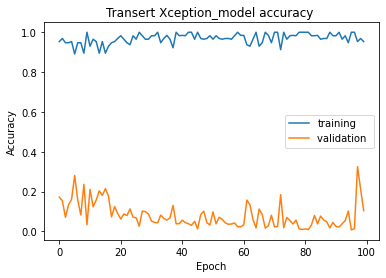

In [48]:
import matplotlib.pyplot as plt
plt.plot(history_xcep.history["accuracy"])
plt.plot(history_xcep.history['loss'])
plt.title("Transert Xception_model accuracy ")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["training","validation "])
plt.show()


### 3.2 Comparaison avec l'architecture du modèle VGG16 pré_entrainé

In [50]:
# Import Xception trained model
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
vgg = VGG16(
    weights='imagenet',
    include_top=False, 
    pooling='avg',
    input_shape=(229,229,3))
    
#en entraine seulement le nouveau classifier et on ne ré-entraine pas les autres couches  
for layer in vgg.layers:
    layer.trainable = False

# Add new fully-connected layers
vgg_base_output = vgg.output
vgg_base_output = keras.layers.Dense(512, activation='relu')(vgg_base_output)
vgg_base_output = Dropout(0.2)(vgg_base_output)
# Output : new classifier
vgg_predictions = keras.layers.Dense(num_classes, activation='softmax')(vgg_base_output)

# Define new model
vgg = Model(inputs=vgg.input,outputs=vgg_predictions)
vgg.summary()


58900480/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 229, 229, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 229, 229, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 229, 229, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 114, 114, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 114, 114, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 114, 114, 128)     147584    
                                                            

In [51]:
#define new model
my_vgg_model=Model(inputs=vgg.input,outputs=vgg_predictions)
my_vgg_model.compile(optimizer="adam",
                       loss="categorical_crossentropy",
                       metrics=["accuracy"])

FIGS_PATH = os.path.join(VM_ROOT, "figures")
os.makedirs(FIGS_PATH, exist_ok=True)
keras.utils.plot_model(model, FIGS_PATH + "/transfer_vgg16_model.png", show_shapes=True)


vgg_train_datagen = ImageDataGenerator(rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  channel_shift_range=20,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                    target_size=(229,229),
                                                    shuffle=True,
                                                    batch_size=32,
                                                    class_mode="categorical")


vgg_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


val_generator = val_datagen.flow_from_directory(VAL_PATH,
                                          target_size=(229,229),
                                          shuffle=False,
                                          batch_size=32,
                                          class_mode='categorical')

Found 89 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


In [52]:
model.compile(optimizer="adam", 
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [53]:
my_vgg_model.compile(optimizer="adam",
                       loss="categorical_crossentropy",
                       metrics=["accuracy"])

MODELS_PATH = os.path.join(VM_ROOT, "models")
FILE_PATH = MODELS_PATH + "/transfert_vgg16_model.h5"

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=FILE_PATH,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True)

batch_size=32
epochs = 100

history_vgg = model.fit(
                train_generator,
                steps_per_epoch = train_size // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps = val_size // batch_size,
                callbacks=[checkpoint_cb,EarlyStopping])

Epoch 1/100
2/2 [==============================] - 2s 576ms/step - loss: 0.0379 - accuracy: 0.9688
Epoch 2/100
2/2 [==============================] - 1s 490ms/step - loss: 0.4582 - accuracy: 0.9219
Epoch 3/100
2/2 [==============================] - 1s 490ms/step - loss: 0.3501 - accuracy: 0.9298
Epoch 4/100
2/2 [==============================] - 1s 480ms/step - loss: 0.2060 - accuracy: 0.9474
Epoch 5/100
2/2 [==============================] - 1s 521ms/step - loss: 0.0703 - accuracy: 0.9844
Epoch 6/100
2/2 [==============================] - 1s 509ms/step - loss: 0.0753 - accuracy: 0.9531
Epoch 7/100
2/2 [==============================] - 1s 499ms/step - loss: 0.2092 - accuracy: 0.9474
Epoch 8/100
2/2 [==============================] - 1s 495ms/step - loss: 0.0131 - accuracy: 1.0000
Epoch 9/100
2/2 [==============================] - 1s 505ms/step - loss: 0.0987 - accuracy: 0.9688
Epoch 10/100
2/2 [==============================] - 1s 500ms/step - loss: 0.0379 - accuracy: 0.9825
Epoch 11/

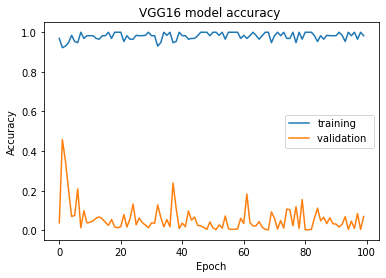

In [56]:
import matplotlib.pyplot as plt
plt.plot(history_vgg.history["accuracy"])
plt.plot(history_vgg.history['loss'])
plt.title("VGG16 model accuracy ")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["training","validation "])
plt.show()


### 3.3 Comparaison avec l'architecture du modèle Resnet50

In [57]:
K.clear_session()
# Import ResNet50 trained model
resnet_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False, 
    pooling='avg',
    input_shape=(229,229,3))

# Dont retrain layers
for rn_layer in resnet_model.layers:
    rn_layer.trainable = False
    
# Add new fully-connected layers
rn_base_output = resnet_model.output
rn_base_output = keras.layers.Dense(512, activation='relu')(rn_base_output)
rn_base_output = Dropout(0.2)(rn_base_output)
# Output : new classifier
rn_predictions = keras.layers.Dense(num_classes, activation='softmax')(rn_base_output)

# Define new model
my_resnet_model = Model(inputs=resnet_model.input,
                        outputs=rn_predictions)
my_resnet_model.compile(optimizer="adam",
                       loss="categorical_crossentropy",
                       metrics=["accuracy"])

FIGS_PATH = os.path.join(VM_ROOT, "figures")
os.makedirs(FIGS_PATH, exist_ok=True)
keras.utils.plot_model(model, FIGS_PATH + "/transfer_resnet50_model.png", show_shapes=True)

# Data generator on train set with Data Augmentation
# and preprocess_input Resnet
# Validation set is define here

rn_train_datagen = ImageDataGenerator(rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  channel_shift_range=20,
                                  horizontal_flip=True,
                                  preprocessing_function=tf.keras.applications.resnet.preprocess_input)

train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                    target_size=(229,229),
                                                    shuffle=True,
                                                    batch_size=32,
                                                    class_mode="categorical")


rn_val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)


val_generator = val_datagen.flow_from_directory(VAL_PATH,
                                          target_size=(229,229),
                                          shuffle=False,
                                          batch_size=32,
                                          class_mode='categorical')

94781440/94765736 [==============================] - 0s 0us/step
Found 89 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


In [58]:
MODELS_PATH = os.path.join(VM_ROOT, "models")
FILE_PATH = MODELS_PATH + "/transfert_resnet50_model.h5"

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=FILE_PATH,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True)

batch_size=32
epochs =100

history_res = model.fit(
                train_generator,
                steps_per_epoch = train_size // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps = val_size // batch_size,
                callbacks=[checkpoint_cb,EarlyStopping])

Epoch 1/100
2/2 [==============================] - 1s 553ms/step - loss: 0.0862 - accuracy: 0.9649
Epoch 2/100
2/2 [==============================] - 1s 492ms/step - loss: 0.0724 - accuracy: 0.9844
Epoch 3/100
2/2 [==============================] - 1s 488ms/step - loss: 0.0491 - accuracy: 0.9825
Epoch 4/100
2/2 [==============================] - 1s 484ms/step - loss: 0.0048 - accuracy: 1.0000
Epoch 5/100
2/2 [==============================] - 1s 481ms/step - loss: 0.0418 - accuracy: 0.9844
Epoch 6/100
2/2 [==============================] - 1s 493ms/step - loss: 0.0300 - accuracy: 0.9844
Epoch 7/100
2/2 [==============================] - 1s 491ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 8/100
2/2 [==============================] - 1s 395ms/step - loss: 0.0128 - accuracy: 1.0000
Epoch 9/100
2/2 [==============================] - 1s 481ms/step - loss: 0.0200 - accuracy: 1.0000
Epoch 10/100
2/2 [==============================] - 1s 476ms/step - loss: 0.0136 - accuracy: 1.0000
Epoch 11/

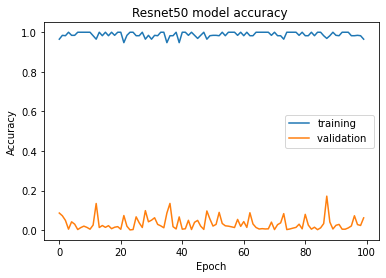

In [59]:
import matplotlib.pyplot as plt
plt.plot(history_res.history["accuracy"])
plt.plot(history_res.history['loss'])
plt.title("Resnet50 model accuracy ")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["training","validation "])
plt.show()


### 3.4. Optimization des paramètres sur la couche classifier du modèle Xception

Ici nous allons utiliser kerastuner pour améliorer les paramètres de la couche que nous avons ajouté au moèle Xception de Keras et séléctionner les meilleurs

In [60]:
def model_builder(hp):
    # Load base model
    xception_model = tf.keras.applications.xception.Xception(
        weights='imagenet',
        include_top=False,
        pooling='avg',
        input_shape=(229,229,3))
    
    for layer in xception_model.layers:
        layer.trainable = False
    
    base_output = xception_model.output
    
    # Tune dense units
    hp_units = hp.Int('dense_units',
                      min_value=64,
                      max_value=600,
                      step=64,
                      default=512)

    base_output = Dense(units=hp_units, 
                        activation='relu')(base_output)
    
    base_output = Dropout(0.2)(base_output)
    
    # Output : new classifier
    predictions = Dense(num_classes, activation='softmax')(base_output)

    # Define new model
    my_xcept_model = Model(inputs=xception_model.input,
                       outputs=predictions)
    
    # Tune learning rate
    hp_learning_rate = hp.Choice(
        name='learning_rate',
        values=[1e-2, 1e-3, 1e-4,1e-5])

    my_xcept_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"])
    
    return my_xcept_model

In [61]:
!pip install -q -U keras-tuner

In [62]:
import keras_tuner as kt

il prend beaucoup du temps !!!!


## 4. Xception fine tuning

In [66]:
def xception_fine_tune(nb_layers):
    # Load the pre trained model
    hypermodel_tuning = load_model('./xception_hypermodel.h5')
    
    # re train the last layers
    for i, layer in enumerate(hypermodel_tuning.layers):
        if i < nb_layers:
            layer.trainable = False
        else:
            layer.trainable = True
            
    # Compile model
    hypermodel_tuning.compile(
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=["accuracy"])
    
    return hypermodel_tuning

In [67]:
from re import VERBOSE
from keras.callbacks import  EarlyStopping,ModelCheckpoint
MODELS_PATH = os.path.join(VM_ROOT, "models")
FILE_PATH = MODELS_PATH + "/tuned_xcept_model.h5"

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=FILE_PATH,
                                                monitor='val_accuracy',
                                                save_best_only=True,
                                                verbose=1,
                                                mode='max')


# Define a early stopping
EarlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1)

In [ ]:
# pour remédier overfitting...technique job out ou plus d'augmentation ou méthode de régulation

### 3.5 Comparaison entre les différentes architectures des modèles :

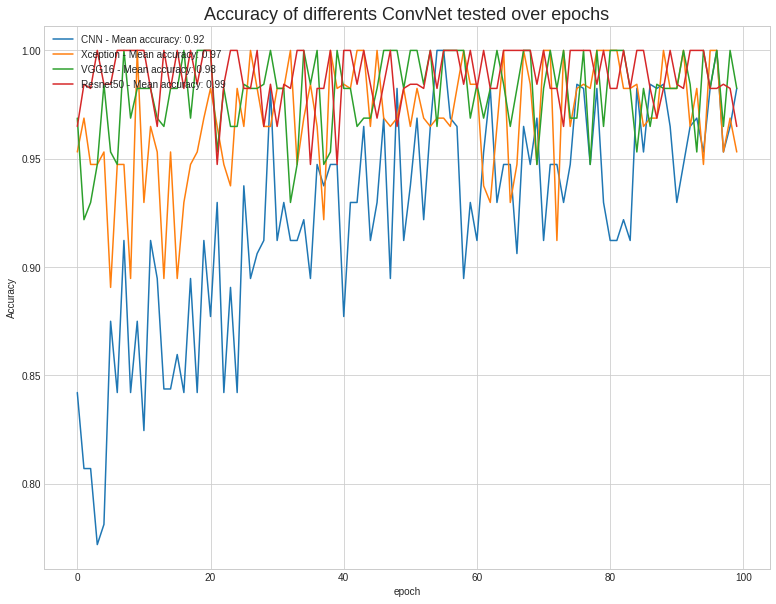

In [73]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(13,10))
    plt.plot(history_cnn.history['accuracy'],
             label='CNN - Mean accuracy: {:.2f}'.format(
                 np.mean(history_cnn.history['accuracy'])))
    plt.plot(history_xcep.history['accuracy'],
             label='Xception - Mean accuracy: {:.2f}'.format(
                 np.mean(history_xcep.history['accuracy'])))
    plt.plot(history_vgg.history['accuracy'],
             label='VGG16 - Mean accuracy: {:.2f}'.format(
                 np.mean(history_vgg.history['accuracy'])))
    plt.plot(history_res.history['accuracy'],
             label='Resnet50 - Mean accuracy: {:.2f}'.format(
                 np.mean(history_res.history['accuracy'])))
  
    plt.title('Accuracy of differents ConvNet tested over epochs',
              fontsize=18)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()